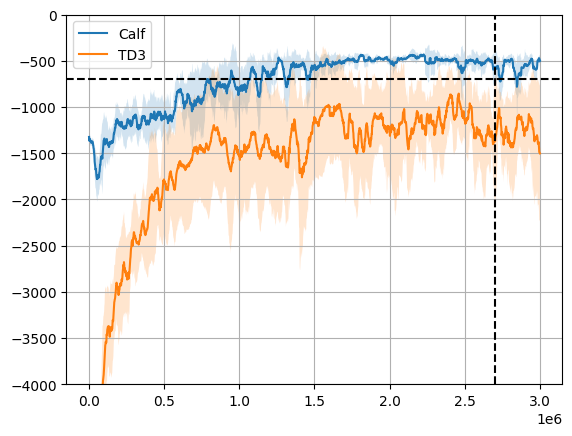

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import root_scalar


calfq_data = pd.read_csv('expdata/calfq_ellipse.csv')
td3_data = pd.read_csv('expdata/td3.csv')

def select_metrics(data, metric_name):
    return data[data["key"] == metric_name]



means = select_metrics(calfq_data, "charts/episodic_return_rolling_20").groupby('step')["value"].mean()
stds = select_metrics(calfq_data, "charts/episodic_return_rolling_20").groupby('step')["value"].std()

plt.plot(means, label='Calf')
plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)
plt.axhline(y=-700, color='black', linestyle='--')
means = select_metrics(td3_data, "charts/episodic_return_rolling_20").groupby('step')["value"].mean()
stds = select_metrics(td3_data, "charts/episodic_return_rolling_20").groupby('step')["value"].std()

plt.plot(means, label='TD3')
plt.axvline(x=0.9 * 3_000_000, color='black', linestyle='--')
plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)
plt.ylim(-4000, 0)
plt.legend()
plt.grid()
plt.show()


In [ ]:
print("CALFQ GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)")

is_in_hole =select_metrics(calfq_data, "episode_stats/is_in_hole")
is_in_hole = is_in_hole[is_in_hole["step"] >= 2_700_000]
print(is_in_hole.groupby("run_id")["value"].mean().mean(),  "+-", is_in_hole.groupby("run_id")["value"].mean().std())

print("TD3 GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)")
is_in_hole =select_metrics(td3_data, "episode_stats/is_in_hole")
is_in_hole = is_in_hole[is_in_hole["step"] >= 2_700_000]
print(is_in_hole.groupby("run_id")["value"].mean().mean(), "+-", is_in_hole.groupby("run_id")["value"].mean().std())

print("--------------------------------")

print("CALFQ HIGH COST REGION AVOIDANCE RATE AFTER 2.7M STEPS (closer to 1 is better)")
high_cost_region = select_metrics(calfq_data, "episode_stats/n_in_spot")
high_cost_region = high_cost_region[high_cost_region["step"] >= 2_700_000]
print(1 - high_cost_region.groupby("run_id")["value"].mean().mean(), "+-", high_cost_region.groupby("run_id")["value"].mean().std())

print("TD3 HIGH COST REGION AVOIDANCE RATE AFTER 2.7M STEPS (closer to 1 is better)")
high_cost_region = select_metrics(td3_data, "episode_stats/n_in_spot")
high_cost_region = high_cost_region[high_cost_region["step"] >= 2_700_000]
print(1 - high_cost_region.groupby("run_id")["value"].mean().mean(), "+-", high_cost_region.groupby("run_id")["value"].mean().std())

CALFQ GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)
0.991 +- 0.007416198487095669
TD3 GOAL REACHING RATE AFTER 2.7M STEPS (closer to 1 is better)
0.5720000000000001 +- 0.340782188501688
--------------------------------
CALFQ HIGH COST REGION AVOIDANCE RATE AFTER 2.7M STEPS (closer to 1 is better)
0.99539 +- 0.0014892708879776617
TD3 HIGH COST REGION AVOIDANCE RATE AFTER 2.7M STEPS (closer to 1 is better)
0.9906826666666667 +- 0.00533807986701835


In [4]:
from scipy.optimize import fsolve

def dD2(y, x0, y0):
    return -9*(y - 2)*(0.81 - x0 - 2.25*(y - 2)**2) + 2*(y - y0)

root = fsolve(dD2, x0=1.5, args=(1, 1))

In [12]:
def distance_to_parabola(x0, y0):
    """
    Computes the shortest distance from point (x0, y0) to the parabola
    x = 0.81 - 2.25(y - 2)^2.

    Returns:
        distance: float - the shortest distance
        x_closest: float - x-coordinate on the parabola
        y_closest: float - y-coordinate on the parabola
    """
    from scipy.optimize import fsolve
    import numpy as np

    def dD2(y):
        return -9 * (y - 2) * (0.81 - x0 - 2.25 * (y - 2) ** 2) + 2 * (y - y0)

    y_closest = fsolve(dD2, x0=y0)[0]
    x_closest = 0.81 - 2.25 * (y_closest - 2) ** 2
    distance = np.sqrt((x_closest - x0) ** 2 + (y_closest - y0) ** 2)

    return distance

In [16]:
for i in range(1500): 
    distance_to_parabola(3, 1)

/tmp/ipykernel_3155923/172766554.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  y_closest = fsolve(dD2, x0=y0)[0]
/tmp/ipykernel_3155923/172766554.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  y_closest = fsolve(dD2, x0=y0)[0]


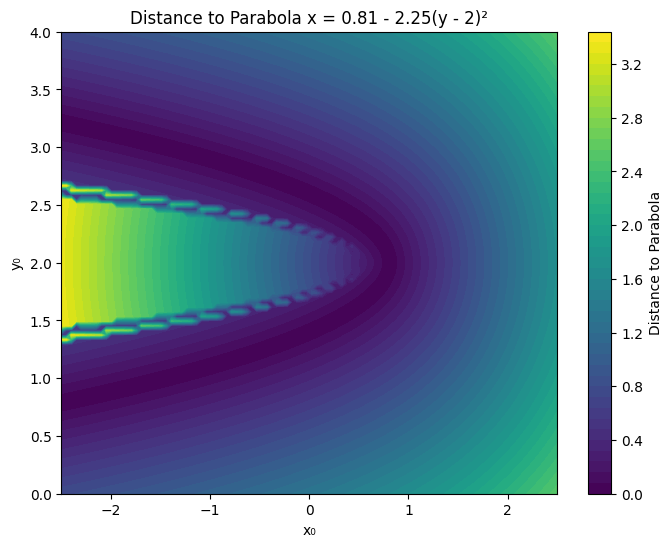

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Your function
from scipy.optimize import minimize_scalar
import numpy as np

def distance_to_parabola(x0, y0):
    """
    Robustly computes the shortest distance from point (x0, y0)
    to the parabola x = 0.81 - 2.25(y - 2)^2 using scalar minimization.
    
    Returns:
        distance: float - shortest distance
        x_closest: float - x on the parabola
        y_closest: float - y on the parabola
    """
    def D2(y):  # Squared distance function
        x_parabola = 0.81 - 2.25 * (y - 2)**2
        return (x_parabola - x0)**2 + (y - y0)**2

    result = minimize_scalar(D2, bounds=(0, 4), method='bounded')

    y_closest = result.x
    x_closest = 0.81 - 2.25 * (y_closest - 2)**2
    distance = np.sqrt(result.fun)

    return distance

# Create grid of x0 and y0 values
x_vals = np.linspace(-2.5, 2.5, 100)
y_vals = np.linspace(0, 4, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Evaluate distance at each point
Z = np.vectorize(distance_to_parabola)(X, Y)

# Plot as a heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label="Distance to Parabola")
plt.title("Distance to Parabola x = 0.81 - 2.25(y - 2)²")
plt.xlabel("x₀")
plt.ylabel("y₀")
plt.show()